In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb
import lightgbm as lgb

from catboost import Pool, CatBoostRanker

In [3]:
data = pd.read_parquet'path_to_file')

**EDA & preprocessing**

In [4]:
data.describe()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
count,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,...,2.352580e+05,2.352580e+05,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000
mean,0.677869,14828.413401,1.911960,0.206233,1.189847,0.550272,1.960082,0.803964,0.097557,0.541174,...,4.763432e+02,1.046698e+04,0.070299,0.740710,11.067947,0.281747,0.027033,0.000269,22.457910,9.560379
std,0.830033,8193.945170,1.237374,0.579089,1.037233,0.790947,1.203534,0.339955,0.266035,0.419973,...,1.954840e+04,2.649584e+06,0.100721,0.352800,15.336861,0.392089,0.033351,0.002088,63.708018,14.347378
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8215.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.666667,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.620522,0.000000,0.000000,0.006703,0.000000,4.000000,2.000000
50%,0.000000,14935.000000,2.000000,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.500000,...,0.000000e+00,0.000000e+00,0.000000,0.926779,9.448900,0.000000,0.017761,0.000008,12.000000,5.500000
75%,1.000000,21580.000000,3.000000,0.000000,2.000000,1.000000,3.000000,1.000000,0.000000,1.000000,...,1.000000e+00,4.000000e-01,0.142857,0.999613,16.146733,0.500000,0.034954,0.000109,28.000000,12.000000
max,4.000000,29995.000000,31.000000,18.000000,27.000000,9.000000,31.000000,1.000000,1.000000,1.000000,...,1.731553e+06,8.000000e+08,0.818182,1.000000,2506.799764,1.000000,0.711261,0.250000,15074.000000,1552.000000


In [ ]:
print("Пропущенные значения в каждом столбце:")
print(data.isnull().sum())

Пропущенные значения в каждом столбце:
rank           0
query_id       0
feature_0      0
feature_1      0
feature_2      0
              ..
feature_139    0
feature_140    0
feature_141    0
feature_142    0
feature_143    0
Length: 146, dtype: int64


In [4]:
not_un = []

for col in data.drop(columns=['query_id', 'rank']).columns:
  if data[col].nunique() == 1:
    print(col, data[col].unique())
    not_un.append(col)

data = data.drop(columns=not_un)

feature_64 [0]
feature_65 [0]
feature_72 [1]
feature_100 [0]


In [ ]:
# Поиск сильно коррелированных пар признаков
print("Сильно коррелированные пары признаков (|r| > 0.9):")
correlation_matrix = data.corr()
high_corr = correlation_matrix.abs().stack().reset_index()
high_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr = high_corr[high_corr['Feature 1'] != high_corr['Feature 2']]  # Исключить диагональ
high_corr = high_corr[high_corr['Correlation'] > 0.9]
print(high_corr.sort_values(by='Correlation', ascending=False))

Сильно коррелированные пары признаков (|r| > 0.9):
         Feature 1    Feature 2  Correlation
1457     feature_8   feature_35     1.000000
5264    feature_35    feature_8     1.000000
3134    feature_20    feature_8     1.000000
1442     feature_8   feature_20     1.000000
5276    feature_35   feature_20     1.000000
...            ...          ...          ...
525      feature_1  feature_101     0.902093
9147    feature_62   feature_57     0.901720
8442    feature_57   feature_62     0.901720
15134  feature_108   feature_83     0.901478
11750   feature_83  feature_108     0.901478

[226 rows x 3 columns]


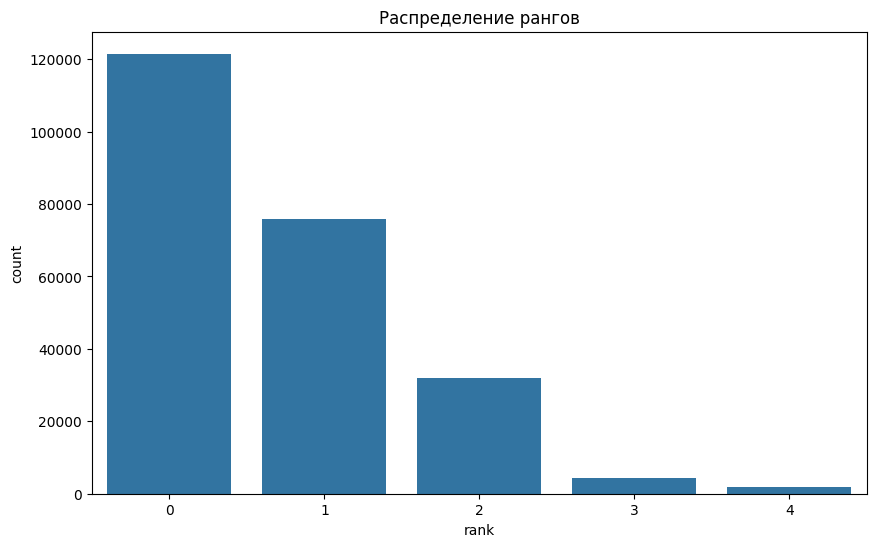

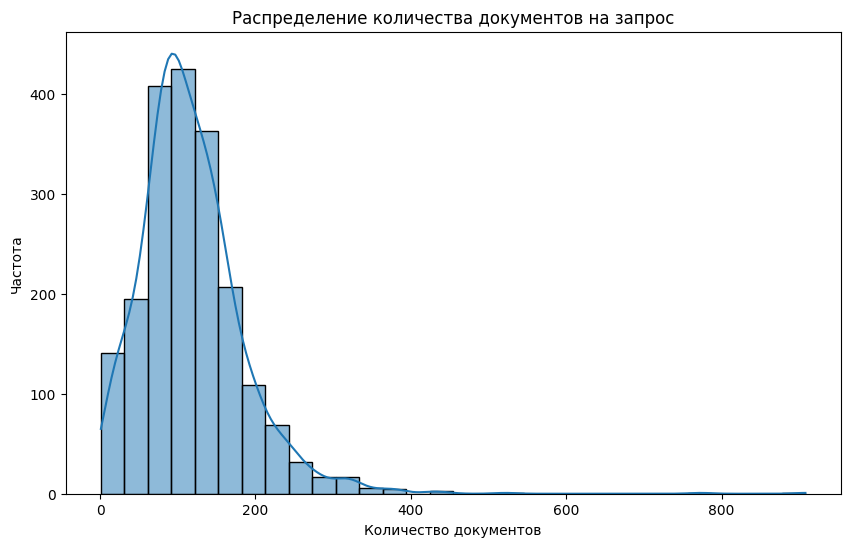

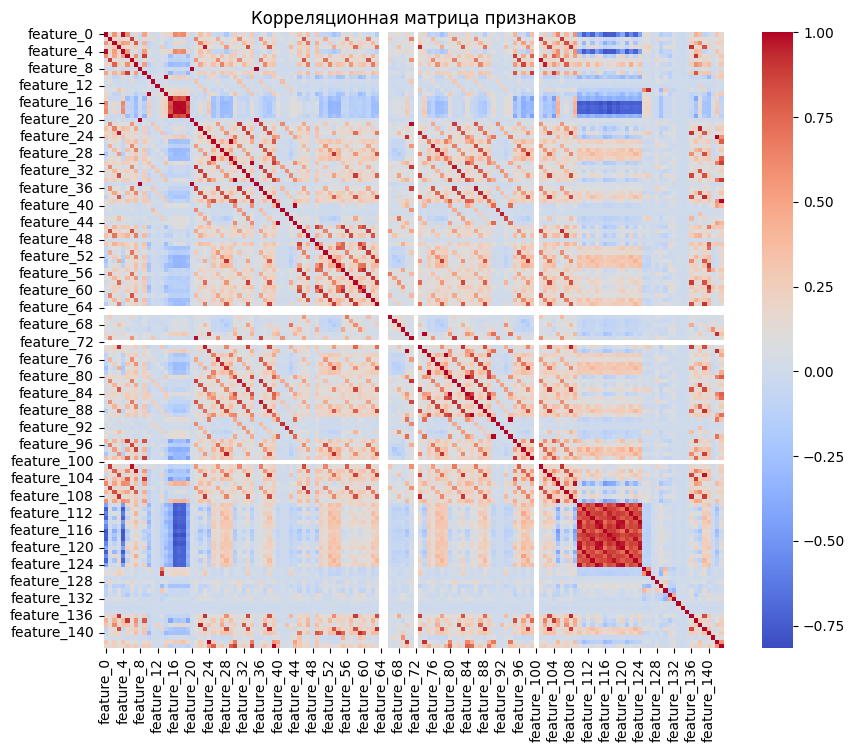

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rank', data=data)
plt.title('Распределение рангов')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data.groupby('query_id').size(), bins=30, kde=True)
plt.title('Распределение количества документов на запрос')
plt.xlabel('Количество документов')
plt.ylabel('Частота')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(data.drop(['rank', 'query_id'], axis=1).corr(), annot=False, cmap='coolwarm')
plt.title('Корреляционная матрица признаков')
plt.show()


In [ ]:
max_ranks = data.groupby('query_id')['rank'].max().reset_index()

max_rank_details = data.merge(max_ranks, on=['query_id', 'rank'], how='inner')

unique_max_ranks = max_rank_details.groupby('query_id').size()

print("Количество уникальных максимальных рангов для каждого query_id:")
print(unique_max_ranks)

Количество уникальных максимальных рангов для каждого query_id:
query_id
10        3
25       11
40        2
55        1
70        1
         ..
29935     3
29950     2
29965     2
29980     1
29995     1
Length: 2000, dtype: int64


Данные имеют мультиколлениарные признаки. Удалим их. Примем отсечку в корреляция = 0.9

In [5]:
# Вычисление матрицы корреляции
corr_matrix = data.corr()

columns = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) >= 0.90:
            colname = corr_matrix.columns[i]
            columns.add(colname)

data = data.drop(columns=columns)

Пишем функции метрик.

Принимаем слудеющие метрики: ndcg, precision at k, pFound



*   Precision at K измеряет долю релевантных результатов в первых K позициях списка рекомендаций или результатов поиска. Precision at K важен, потому что пользователи обычно обращают внимание только на первые несколько результатов. Если первые результаты релевантны, пользователь останется доволен опытом поиска.
*   pFound — это метрика, оценивающая вероятность того, что пользователь найдет хотя бы один релевантный результат в списке рекомендаций. pFound учитывает не только присутствие релевантных результатов, но и вероятность того, что пользователь продолжит просмотр результатов до того, как найдет нужную информацию. Это важно для понимания удовлетворенности пользователя и его взаимодействия с системой.
*   NDCG оценивает качество ранжирования с учетом позиции каждого релевантного элемента в списке, дисконтируя значение каждого последующего элемента. Эта метрика учитывает не только наличие релевантных результатов, но и их позиции. Более важные или более релевантные результаты должны быть выше в списке, и NDCG это учитывает, давая более высокие баллы за релевантные результаты на более высоких позициях.





In [25]:
def precision_at_k(actual, predicted, k):
    top_k_preds = predicted.argsort()[-k:][::-1]
    top_k_labels = actual[top_k_preds]
    relevant_items = np.where(top_k_labels > 0)[0].size
    return relevant_items / float(k)


def pFound(predictions, ranks, max_rank=4, decay=0.85, top=5):

    normalized_relevances = ranks / max_rank

    predictions_positive = predictions - np.min(predictions)
    normalized_scores = predictions_positive / np.max(predictions_positive)

    indices_sorted = np.argsort(normalized_scores)[::-1]

    if top is None or top > len(indices_sorted):
        top = len(indices_sorted)

    p_found = 0.0
    p_reach = 1.0

    for i in range(top):
        idx = indices_sorted[i]
        relevance = normalized_relevances[idx]
        p_found += p_reach * relevance
        if i < top - 1:
            p_reach *= (1 - relevance) * decay

    return p_found

Есть три основных подхода: pointwise, pairwise и listwise. Эти подходы различаются способом обработки данных и определением функции потерь при обучении моделей.

*   **Pointwise** подход рассматривают задачу ранжирования как задачу регрессии или классификации на уровне отдельных элементов (точек). Но он не учитывает взаимосвязи между элементами в списке, поэтому его пробовать не станем.
*   **Pairwise** подход фокусируется на правильном упорядочивании пар объектов.
*   **Listwise** подход рассматривает задачу ранжирования в контексте целого списка объектов.






**Pairwise подход**

Пробуем:

 XGBRanker,

 lgb c objective = rank_xendcg,

 catboost c loss_function = PairLogitPairwise



In [28]:
group_kfold = GroupKFold(n_splits=5)

total_ndcg_score = 0
ndcg_lst_xgbanker = []
pFound_lst_xgbanker = []
pres_lst_xgbanker = []

for fold_idx, (train_idx, test_idx) in enumerate(group_kfold.split(data, groups=data['query_id'])):
    train_data, test_data = data.iloc[train_idx], data.iloc[test_idx]

    train_groups = train_data.groupby('query_id').size().tolist()
    model = xgb.XGBRanker()
    model.fit(train_data.drop(['rank', 'query_id'], axis=1), train_data['rank'], group=train_groups)

    test_preds = model.predict(test_data.drop(['rank', 'query_id'], axis=1))
    true_relevance = test_data['rank'].values

    ndcg_score_ = ndcg_score(np.asarray([true_relevance]), np.asarray([test_preds]), k=5)
    #pFound_score = pFound(test_data['rank'].tolist(), test_preds, 1.0)
    pFound_score = pFound(test_preds, true_relevance, max_rank=4, decay=0.85, top=5)
    prec_score = precision_at_k(true_relevance, test_preds, k=5)

    ndcg_lst_xgbanker.append(ndcg_score_)
    pFound_lst_xgbanker.append(pFound_score)
    pres_lst_xgbanker.append(prec_score)

    print(f'Fold {fold_idx + 1} NDCG score: {ndcg_score_}')

print(f'Средний NDCG по всем фолдам: {sum(ndcg_lst_xgbanker) / len(ndcg_lst_xgbanker)}')
print(f'Средний pFound по всем фолдам: {sum(pFound_lst_xgbanker) / len(pFound_lst_xgbanker)}')
print(f'Средний Precision_at_5 по всем фолдам: {sum(pres_lst_xgbanker) / len(pres_lst_xgbanker)}')

Fold 1 NDCG score: 0.7091127585841113
Fold 2 NDCG score: 0.8496074099254249
Fold 3 NDCG score: 0.8496074099254249
Fold 4 NDCG score: 0.9671987306219144
Fold 5 NDCG score: 0.904108408157166
Средний NDCG по всем фолдам: 0.8559269434428083
Средний pFound по всем фолдам: 0.97
Средний Precision_at_5 по всем фолдам: 1.0


In [29]:
params = {
    'objective': 'rank_xendcg',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1
}

group_kfold = GroupKFold(n_splits=5)

ndcg_lst_rank_xendcg = []
pFound_lst_rank_xendcg = []
pres_lst_rank_xendcg = []

for fold_idx, (train_idx, test_idx) in enumerate(group_kfold.split(data, groups=data['query_id'])):
    train_data, test_data = data.iloc[train_idx], data.iloc[test_idx]

    train_groups = train_data.groupby('query_id').size().tolist()
    test_groups = test_data.groupby('query_id').size().tolist()

    lgb_train = lgb.Dataset(data=train_data.drop(['rank', 'query_id'], axis=1),
                            label=train_data['rank'],
                            group=train_groups)

    lgb_test = lgb.Dataset(data=test_data.drop(['rank', 'query_id'], axis=1),
                           label=test_data['rank'],
                           group=test_groups,
                           reference=lgb_train)

    model = lgb.train(params, lgb_train, valid_sets=[lgb_test])

    test_preds = model.predict(test_data.drop(['rank', 'query_id'], axis=1))
    true_relevance = test_data['rank'].values

    ndcg_score_ = ndcg_score(np.asarray([true_relevance]), np.asarray([test_preds]), k=5)
    # pFound_score = pFound(true_relevance, test_preds, 1.0)
    pFound_score = pFound(test_preds, true_relevance, max_rank=4, decay=0.85, top=5)
    prec_score = precision_at_k(true_relevance, test_preds, k=5)

    ndcg_lst_rank_xendcg.append(ndcg_score_)
    pFound_lst_rank_xendcg.append(pFound_score)
    pres_lst_rank_xendcg.append(prec_score)

    print(f'Fold {fold_idx + 1} NDCG score: {ndcg_score_}')

print(f'Средний NDCG по всем фолдам: {sum(ndcg_lst_rank_xendcg) / len(ndcg_lst_rank_xendcg)}')
print(f'Средний pFound по всем фолдам: {sum(pFound_lst_rank_xendcg) / len(pFound_lst_rank_xendcg)}')
print(f'Средний Precision_at_5 по всем фолдам: {sum(pres_lst_rank_xendcg) / len(pres_lst_rank_xendcg)}')

Fold 1 NDCG score: 0.8029932139884276
Fold 2 NDCG score: 0.9152099486815958
Fold 3 NDCG score: 0.9465034338163679
Fold 4 NDCG score: 0.8496074099254249
Fold 5 NDCG score: 0.8617133824979639
Средний NDCG по всем фолдам: 0.8752054777819559
Средний pFound по всем фолдам: 0.9759062499999999
Средний Precision_at_5 по всем фолдам: 1.0


In [10]:
grouped = data.groupby('query_id')
indices = [group.index for _, group in grouped]

train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
train_data = pd.concat([data.loc[idx] for idx in train_indices])
test_data = pd.concat([data.loc[idx] for idx in test_indices])

train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

ndcg_lst_rank_catboost = []
pFound_lst_catboost = []
pres_lst_catboost = []

group_kfold = GroupKFold(n_splits=5)

train_pool = Pool(data=train_data.drop(['rank', 'query_id'], axis=1),
                  label=train_data['rank'],
                  group_id=train_data['query_id'])

test_pool = Pool(data=test_data.drop(['rank', 'query_id'], axis=1),
                 label=test_data['rank'],
                 group_id=test_data['query_id'])


for fold_idx, (train_idx, test_idx) in enumerate(group_kfold.split(data, groups=data['query_id'])):
    train_data, test_data = data.iloc[train_idx], data.iloc[test_idx]

    train_pool = Pool(data=train_data.drop(['rank', 'query_id'], axis=1),
                      label=train_data['rank'],
                      group_id=train_data['query_id'])

    test_pool = Pool(data=test_data.drop(['rank', 'query_id'], axis=1),
                     label=test_data['rank'],
                     group_id=test_data['query_id'])

    model = CatBoostRanker()
    model.fit(train_pool, eval_set=test_pool, plot=False)

    test_preds = model.predict(test_pool)
    true_relevance = test_data['rank'].values
    predicted_ranks = test_preds.argsort()[::-1]

    ndcg_score_ = ndcg_score(np.asarray([true_relevance]), np.asarray([test_preds]), k=5)
    pFound_score = pFound(true_relevance, test_preds, 1.0)
    prec_score = precision_at_k(true_relevance, test_preds, k=5)

    ndcg_lst_rank_catboost.append(ndcg_score_)
    pFound_lst_catboost.append(pFound_score)
    pres_lst_catboost.append(prec_score)

    print(f'Fold {fold_idx + 1} NDCG score: {ndcg_score_}')

print(f'Средний NDCG по всем фолдам: {sum(ndcg_lst_rank_catboost) / len(ndcg_lst_rank_catboost)}')
print(f'Средний pFound по всем фолдам: {sum(pFound_lst_catboost) / len(pFound_lst_catboost)}')
print(f'Средний Precision_at_5 по всем фолдам: {sum(pres_lst_catboost) / len(pres_lst_catboost)}')


Выходные данные были обрезаны до нескольких последних строк (5000).
33:	test: 0.7745117	best: 0.7745117 (33)	total: 20.4s	remaining: 9m 40s
34:	test: 0.7742315	best: 0.7745117 (33)	total: 20.9s	remaining: 9m 36s
35:	test: 0.7741024	best: 0.7745117 (33)	total: 21.4s	remaining: 9m 33s
36:	test: 0.7738203	best: 0.7745117 (33)	total: 21.9s	remaining: 9m 30s
37:	test: 0.7749254	best: 0.7749254 (37)	total: 22.4s	remaining: 9m 26s
38:	test: 0.7753765	best: 0.7753765 (38)	total: 22.9s	remaining: 9m 23s
39:	test: 0.7753672	best: 0.7753765 (38)	total: 23.3s	remaining: 9m 20s
40:	test: 0.7753286	best: 0.7753765 (38)	total: 23.9s	remaining: 9m 17s
41:	test: 0.7751912	best: 0.7753765 (38)	total: 24.3s	remaining: 9m 15s
42:	test: 0.7759064	best: 0.7759064 (42)	total: 24.9s	remaining: 9m 13s
43:	test: 0.7766746	best: 0.7766746 (43)	total: 25.4s	remaining: 9m 11s
44:	test: 0.7772706	best: 0.7772706 (44)	total: 25.9s	remaining: 9m 9s
45:	test: 0.7775253	best: 0.7775253 (45)	total: 26.4s	remaining: 9m 6

**Listwise подход**

Пробуем lambdamart

In [27]:
gkf = GroupKFold(n_splits=5)

ndcg_lst_lambdarank = []
pFound_lst_lambdarank = []
pres_lst_lambdarank = []

params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_at': [5],
    'learning_rate': 0.028588386237886294,
    'max_depth':12,
    'num_leaves': 24,
    'min_data_in_leaf': 23,
    'num_iterations': 100,
    'random_state':42,
    'lambdarank_norm':True,
    'verbose': -1,
    # 'lambdarank_truncation_level': 10
}

for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(data, groups=data['query_id'])):
    train_data, test_data = data.iloc[train_idx], data.iloc[test_idx]
    #weights = train_data['rank'].apply(lambda x: (x + 1)**2)
    lgb_train = lgb.Dataset(data=train_data.drop(['rank', 'query_id'], axis=1),
                            label=train_data['rank'],
                            group=train_data.groupby('query_id').size())
                            # weight=weights)


    lgb_test = lgb.Dataset(data=test_data.drop(['rank', 'query_id'], axis=1),
                           label=test_data['rank'],
                           group=test_data.groupby('query_id').size())

    model = lgb.train(params, lgb_train, valid_sets=[lgb_test])

    test_preds = model.predict(test_data.drop(['rank', 'query_id'], axis=1))
    true_relevance = test_data['rank'].values
    predicted_ranks = test_preds.argsort()[::-1]

    ndcg_score_ = ndcg_score(np.asarray([true_relevance]), np.asarray([test_preds]), k=5)
    #pFound_score = pFound(true_relevance, test_preds, 1.0)
    pFound_score = pFound(test_preds, true_relevance, max_rank=4, decay=0.85, top=5)
    prec_score = precision_at_k(true_relevance, test_preds, k=5)

    ndcg_lst_lambdarank.append(ndcg_score_)
    pFound_lst_lambdarank.append(pFound_score)
    pres_lst_lambdarank.append(prec_score)

    print(f'Fold {fold_idx + 1} NDCG score: {ndcg_score_}')

print(f'Средний NDCG по всем фолдам: {sum(ndcg_lst_lambdarank) / len(ndcg_lst_lambdarank)}')
print(f'Средний pFound по всем фолдам: {sum(pFound_lst_lambdarank) / len(pFound_lst_lambdarank)}')
print(f'Средний Precision_at_5 по всем фолдам: {sum(pres_lst_lambdarank) / len(pres_lst_lambdarank)}')

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 1 NDCG score: 0.82813526413655


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 2 NDCG score: 0.9999999999999999


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 3 NDCG score: 0.7765732350040717


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 4 NDCG score: 0.9576049743407978


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 5 NDCG score: 0.8771850769776058
Средний NDCG по всем фолдам: 0.8878997100918051
Средний pFound по всем фолдам: 1.0
Средний Precision_at_5 по всем фолдам: 1.0


In [14]:
import pandas as pd

def calculate_metrics_averages(*metric_lists):
    """Вычисляет средние значения метрик из переданных списков."""
    return {metric: sum(metric_list) / len(metric_list) if metric_list else None for metric, metric_list in metric_lists}

metrics_lambda_rank = [
    ('NDCG', ndcg_lst_lambdarank),
    ('pFound', pFound_lst_lambdarank),
    ('Precision', pres_lst_lambdarank)
]

metrics_rank_xendcg = [
    ('NDCG', ndcg_lst_rank_xendcg),
    ('pFound', pFound_lst_rank_xendcg),
    ('Precision', pres_lst_rank_xendcg)
]

metrics_xgbanker = [
    ('NDCG', ndcg_lst_xgbanker),
    ('pFound', pFound_lst_xgbanker),
    ('Precision', pres_lst_xgbanker)
]

metrics_catboost = [
    ('NDCG', ndcg_lst_rank_catboost),
    ('pFound', pFound_lst_catboost),
    ('Precision', pres_lst_catboost)
]

res_df = {
    'LambdaRank': calculate_metrics_averages(*metrics_lambda_rank),
    'Rank_Xendcg': calculate_metrics_averages(*metrics_rank_xendcg),
    'XGBRanker': calculate_metrics_averages(*metrics_xgbanker),
    'CatBoost': calculate_metrics_averages(*metrics_catboost)
}

df_results = pd.DataFrame(res_df).T

In [31]:
df_results

,NDCG,pFound,Precision_at_5
LambdaRank,0.887900,1.000000,1.0
Rank_Xendcg,0.875205,0.975906,1.0
XGBRanker,0.855927,0.970000,1.0
CatBoost,0.867863,0.901066,1.0


Общий вывод:

LambdaMart показывает лучшие результаты по метрикам NDCG и pFound, что делает его предпочтительным выбором для задач, где критически важно правильное ранжирование наивысших позиций и уверенность в нахождении релевантных результатов пользователями. Этот алгоритм обеспечивает высочайшую вероятность того, что пользователь найдет наиболее подходящие и релевантные результаты на верхних позициях списка.

Rank_Xendcg показывает хорошие результаты по pFound, но немного уступает LambdaMart, с 0.975906 против 1.0 у LambdaMart. Это делает Rank_Xendcg хорошим выбором для задач, где важно, чтобы пользователи находили релевантные результаты, но LambdaMart предоставляет лучшую гарантию релевантности на высших позициях.

XGBRanker и CatBoost также показывают достойные результаты, особенно в Precision_at_5, но они уступают LambdaMart и Rank_Xendcg по NDCG и pFound, что делает их менее предпочтительными для наиболее критически важных задач ранжирования, где важна точность наивысших позиций и достоверность найденных результатов.

В целом, LambdaMart показывает результаты лучше остальных алгоритмов, поэтому за окончательный алгоритм его и примем

**Дальнейшие возможные шаги по улучшению: **

1. *Детальный анализ ошибок*

Анализ случаев низкой релевантности: Изучить случаи, когда моя модель неправильно ранжировала элементы, особенно те, которые оказались в верхних позициях списка. Попробовать выявить общие характеристики или признаки, которые могут влиять на неправильное ранжирование, чтобы понять, какие изменения необходимо внести в модель.
Изучение характеристик запросов: Проанализировать, как различные типы запросов обрабатываются моей моделью. Важно понять, вызывают ли некоторые запросы систематически худшие результаты из-за недостаточной обучающей выборки или особенностей данных, что может потребовать специальных корректировок в подходах к обучению или предобработке данных.
2. *Работа с признаками*

Добавление новых признаков: Исследовать возможность добавления новых признаков, которые могут улучшить способность модели различать релевантные и нерелевантные элементы. Это может включать в себя как создание признаков на основе существующих данных, так и интеграцию внешних источников информации.
Оптимизация существующих признаков: Пересмотреть важность признаков, используемых в модели, чтобы определить, какие из них вносят мало информации или влияют на точность в отрицательную сторону. Попробовать изменить способы обработки признаков, возможно, улучшив их представление или исключив менее значимые.